# Network Analysis

## Content
1. [Settings and Imports](#settings)
2. [Custom Entities](#custom_entities)
3. [Entity Aliases](#entity_aliases)
4. [Extract Entities](#extract_entities)
5. [Visualization](#visualization)

## Settings and Imports <a name="settings"></a>

In [1]:
# Print out every value 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pprint as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

from itertools import combinations

import string
from wordcloud import WordCloud

%matplotlib inline

In [3]:
import spacy
nlp = spacy.load('en_core_web_trf')

from spacy.tokens import Span
from spacy.tokens import Token
Token.set_extension('ref_n', default ='')
Token.set_extension('ref_t', default ='')

from spacy.pipeline import EntityRuler

from spacy.language import Language

In [4]:
import networkx as nx

Die Daten werden wie üblich, aus der sqlite-Datenbank gelesen

In [5]:
sql = """
SELECT subreddit,
  title || ' ' || text as text 
  -- upvotes, downvotes, category, creation_time, author
FROM post_data
"""

con = sqlite3.connect('./data/reddit_crypto_posts.sqlite')
df = pd.read_sql_query(sql, con)
con.close()

#print some stats of the data 
print(df.head())

        subreddit                                               text
0  CryptoCurrency  You hear about the kid who put in $500 into a ...
1  CryptoCurrency  It's been a crazy ride these past 7 years, but...
2  CryptoCurrency  Elon Musk Is Not One Of Us. Stop Using Him As ...
3  CryptoCurrency  How much will the price of Litecoin move by Mo...
4  CryptoCurrency  Elon Musks affect on crypto is completely exag...


## Custom Entities <a name="custom_entities"></a>

Das Ausgeben der Entities würde zeigen, dass oftmals wichtige Entities wie z.B. 'Bitcoin' übersehen wird.  

Um dieses Problem zu lösen, erweitern wir die spaCy Pipeline mit einem cutsom EntityRuler. dieser wird im folgenden Teil erzeugt, und erhält einige zusätzliche Regeln, mit denen die wichtigsten Tokens zusätzlich noch erkannt werden.  

Die einzelnen Regeln bestehen aus einem (Entity-)Label und einem Pattern, wobei das Label bei den Coins immer als PRODUCT definiert wird. Das Pattern wird nur mit LOWER erweitert, was dazu führ, dass die Groß- und Kleinschreibung ignoriert wird.  
Folglich wird sowohl 'BTC' , 'Btc' und 'btc' erkannt

In [6]:
def print_entities_from_text(text):
    doc = nlp(text)
    print(*[(ent.text,ent.label_) for ent in doc.ents],sep=' ')

In [7]:
#If the method above is executed, it shows that some coins aren't recogniezed as an entity
#thus we need an extension so that spacy detects them 

#first we define the custom entities
patterns = [
    {'label': 'PRODUCT', 'pattern': [{'LOWER':'btc'}]},
    {'label': 'PRODUCT', 'pattern': [{'LOWER':'bitcoin'}]},
    {'label': 'PRODUCT', 'pattern': [{'LOWER':'eth'}]},
    {'label': 'PRODUCT', 'pattern': [{'LOWER':'ethereum'}]},
    {'label': 'PRODUCT', 'pattern': [{'LOWER':'xrp'}]},
    {'label': 'PRODUCT', 'pattern': [{'LOWER':'ripple'}]},
    {'label': 'PRODUCT', 'pattern': [{'LOWER':'xmr'}]},
    {'label': 'PRODUCT', 'pattern': [{'LOWER':'monero'}]},
    {'label': 'PRODUCT', 'pattern': [{'LOWER':'doge'}]},
    {'label': 'PRODUCT', 'pattern': [{'LOWER':'dogecoin'}]},
]


#the spacy class EntityRules allows us to add the custom entities
#ruler = EntityRuler(nlp, overwrite_ents=True)
ruler = nlp.add_pipe("entity_ruler",before='ner')
ruler.add_patterns(patterns)

In [8]:
#This method has a quite long output and should only be called for exploring 
#df['text'].map(print_entities_from_text)

## Entity Aliases <a name="entity_aliases"></a>

Verschiedene Entities können innerhalb der Texte unterschiedlich bennant sein. So ist 'BTC' das gleiche wie 'Bitcoin'.  
(Zumindest ist dies für diesen Use-Case so. Manchmal wird z.B. 'BTC' für das Börsenasset benutzt, jedoch wird dies hier nicht weiter beachtet)  

Deshalb werden zunächst einige 'Aliases' (=Synonyme) definiert.  
Im darauffolgenen Schritt, werden diese Aliases mittels der Function 'alias_resolver()' aufgelöst. Das @Language.component symbolisert spaCy, dass dies eine Function ist, welche in die Pipeline mit eingebunden werden kann (Wird seit Version 3 benötigt).

In [9]:
entity_aliases = {
    'btc':('bitcoin','PRODUCT'),
    'eth':('ethereum','PRODUCT'),
    'xrp':('ripple','PRODUCT'),
    'xmr':('monero','PRODUCT'),
    'doge coin': ('dogecoin','PRODUCT'),
    'doge': ('dogecoin','PRODUCT'),
    'uniswap v1':('uniswap','PRODUCT'),
    'elon': ('elon musk','PERSON'),
    'mark': ('mark zuckerberg','PERSON'),
    'marky': ('mark zuckerberg','PERSON'),
    'jeff': ('jeff bezos', 'PERSON'),
    'bezos': ('jeff bezos', 'PERSON'),
    'satoshi':('satoshi nakamoto','PERSON'),
    'vitalik':('vitalik buterin','PERSON'),
    #joe could either mean joe rogan or joe biden
    #a lot of the texts is about the joe rogan podcast so we will use this
    'joe' : ('joe rogan','PERSON'),
    #board of directors could be any company 
    'board of directors':('',''),
    'the audit committee':('',''),
    #some entities seem quite weird, so we remove them
    'cumdoggy':('','')
}

In [10]:
#creates reference from each entity to itself
@Language.component('init_coref')
def init_coref(doc):
    for e in doc.ents:
        if e.label_ in ['ORG','GOV','PERSON','PRODUCT']:
            e[0]._.ref_n, e[0]._.ref_t = e.text, e.label_
    return doc

#resolves synonymes or acronyms etc. to the matching entitiy
@Language.component('alias_resolver')
def alias_resolver(doc):
    for ent in doc.ents:
        token= ent[0].text       
        if token.lower() in entity_aliases:
            a_name, a_type = entity_aliases[token.lower()]
            ent[0]._.ref_n, ent[0]._.ref_t = a_name, a_type
    return propagate_ent_type(doc)


def propagate_ent_type(doc):
    ents=[]
    for e in doc.ents:
        if e[0]._.ref_n != "": 
            e = Span(doc, e.start, e.end, label= e[0]._.ref_t)
        ents.append(e)
    doc.ents=tuple(ents)
    return doc

nlp.add_pipe('init_coref')
nlp.add_pipe('alias_resolver')

<function __main__.init_coref(doc)>

<function __main__.alias_resolver(doc)>

## Extract the Entities <a name="extract_entities"></a>

Nachdem die spaCy Pipeline erweitert wurde, können nun die Entity-Kombinationen aus den einzelnen Posts extrahiert werden. Dies macht die Funktion 'extract_coocs()'.

In [11]:
#returns the list of entities pairs from given Doc (of specified types)
def extract_coocs(doc, include_types = ['ORG','GOV','PERSON','PRODUCT']):
    ents = set([e[0]._.ref_n.lower() for e in doc.ents if e[0]._.ref_t in include_types])   
    return list(combinations(sorted(ents),2))

In [12]:
%%time
ents = []
for index, row in df.iterrows():
    doc = nlp(row['text'])
    ents.append(extract_coocs(doc))
df['entities_comb'] = ents

Token indices sequence length is longer than the specified maximum sequence length for this model (821 > 512). Running this sequence through the model will result in indexing errors


Wall time: 50min 27s


In [13]:
df.head()

,subreddit,text,entities_comb
0,CryptoCurrency,You hear about the kid who put in $500 into a ...,[]
1,CryptoCurrency,"It's been a crazy ride these past 7 years, but...","[(bitcoin, bmw)]"
2,CryptoCurrency,Elon Musk Is Not One Of Us. Stop Using Him As ...,"[(bitcoin, dogecoin), (bitcoin, elon musk), (b..."
3,CryptoCurrency,How much will the price of Litecoin move by Mo...,[]
4,CryptoCurrency,Elon Musks affect on crypto is completely exag...,[]


Nachdem die Entity-Kombinationen extrahiert wurden, können diese gezählt werden.  
Die Ergebnisse werden in einem neuen DataFrame gesichert, wobei eine Entity in der Spalte 'source', und die anderen Entity in der Spalte 'target' vorkommen. Die Spalte 'weight' speicher, in wie vielen Reddit Posts die beiden Entities gemeinsam aufgetreten sind.

In [14]:
#count how often each entity_combination appears
comb_count = {}
for index, row in df.iterrows():
    for comb in row['entities_comb']:
        comb_count[comb] = (comb_count.get(comb, 0) + 1)
#print(comb_count)

In [15]:
#convert the count to a list and then to a dataframe
# dict entries are like :
# (source,target): weigth
coocs = []
for count in comb_count:
    graph_data = {'source': count[0], 'target': count[1], 'weight': comb_count[count]}
    coocs.append(graph_data)

cooc_df = pd.DataFrame(coocs).sort_values(by=['weight'],ascending=False)

In [16]:
cooc_df.head()

,source,target,weight
106,bitcoin,ethereum,266
301,ripple,sec,184
242,bitcoin,monero,184
244,bitcoin,ripple,86
2,bitcoin,elon musk,62


## Visualization <a name="visualization"></a>

Die Library networkx bietet die Möglichkeit, das DataFrame in einen Graphen umzuwandeln. Die Spalten sind bereits entsprechend benannt. Der Übersicht halber werden nur Verbindungen aufgenommen, die in mindestens 10 Reddit Posts zusammen vorkommen. Dies reduziert die Anzahl der Knoten und Kanten

In [17]:
# create the graph with networkx
graph = nx.from_pandas_edgelist(cooc_df.query('weight > 10')
                                ,source='source', target='target',edge_attr=True)

Folgende Zelle gibt die Knoten und Kanten des Graphen aus.

In [18]:
graph.nodes
graph.edges

NodeView(('bitcoin', 'ethereum', 'ripple', 'sec', 'monero', 'elon musk', 'dogecoin', 'tesla', 'coinbase', 'microstrategy', 'binance', 'reddit', 'vitalik', 'visa', 'paypal', 'michael saylor', 'kraken', 'satoshi', 'uniswap', 'vitalik buterin', 'brad garlinghouse', 'satoshi nakamoto', 'amazon', 'cardano', 'gary gensler', 'mark zuckerberg', 'google', 'defi', 'gme', 'david schwartz'))

EdgeView([('bitcoin', 'ethereum'), ('bitcoin', 'monero'), ('bitcoin', 'ripple'), ('bitcoin', 'elon musk'), ('bitcoin', 'dogecoin'), ('bitcoin', 'tesla'), ('bitcoin', 'coinbase'), ('bitcoin', 'sec'), ('bitcoin', 'microstrategy'), ('bitcoin', 'binance'), ('bitcoin', 'paypal'), ('bitcoin', 'reddit'), ('bitcoin', 'michael saylor'), ('bitcoin', 'satoshi'), ('bitcoin', 'satoshi nakamoto'), ('bitcoin', 'amazon'), ('bitcoin', 'cardano'), ('bitcoin', 'visa'), ('bitcoin', 'mark zuckerberg'), ('bitcoin', 'google'), ('bitcoin', 'gme'), ('ethereum', 'ripple'), ('ethereum', 'dogecoin'), ('ethereum', 'coinbase'), ('ethereum', 'monero'), ('ethereum', 'binance'), ('ethereum', 'reddit'), ('ethereum', 'vitalik'), ('ethereum', 'visa'), ('ethereum', 'sec'), ('ethereum', 'elon musk'), ('ethereum', 'uniswap'), ('ethereum', 'vitalik buterin'), ('ethereum', 'cardano'), ('ethereum', 'mark zuckerberg'), ('ethereum', 'defi'), ('ripple', 'sec'), ('ripple', 'dogecoin'), ('ripple', 'brad garlinghouse'), ('ripple', '

Dieser Graph kann nun mittels matplotlib visualisiert werden.

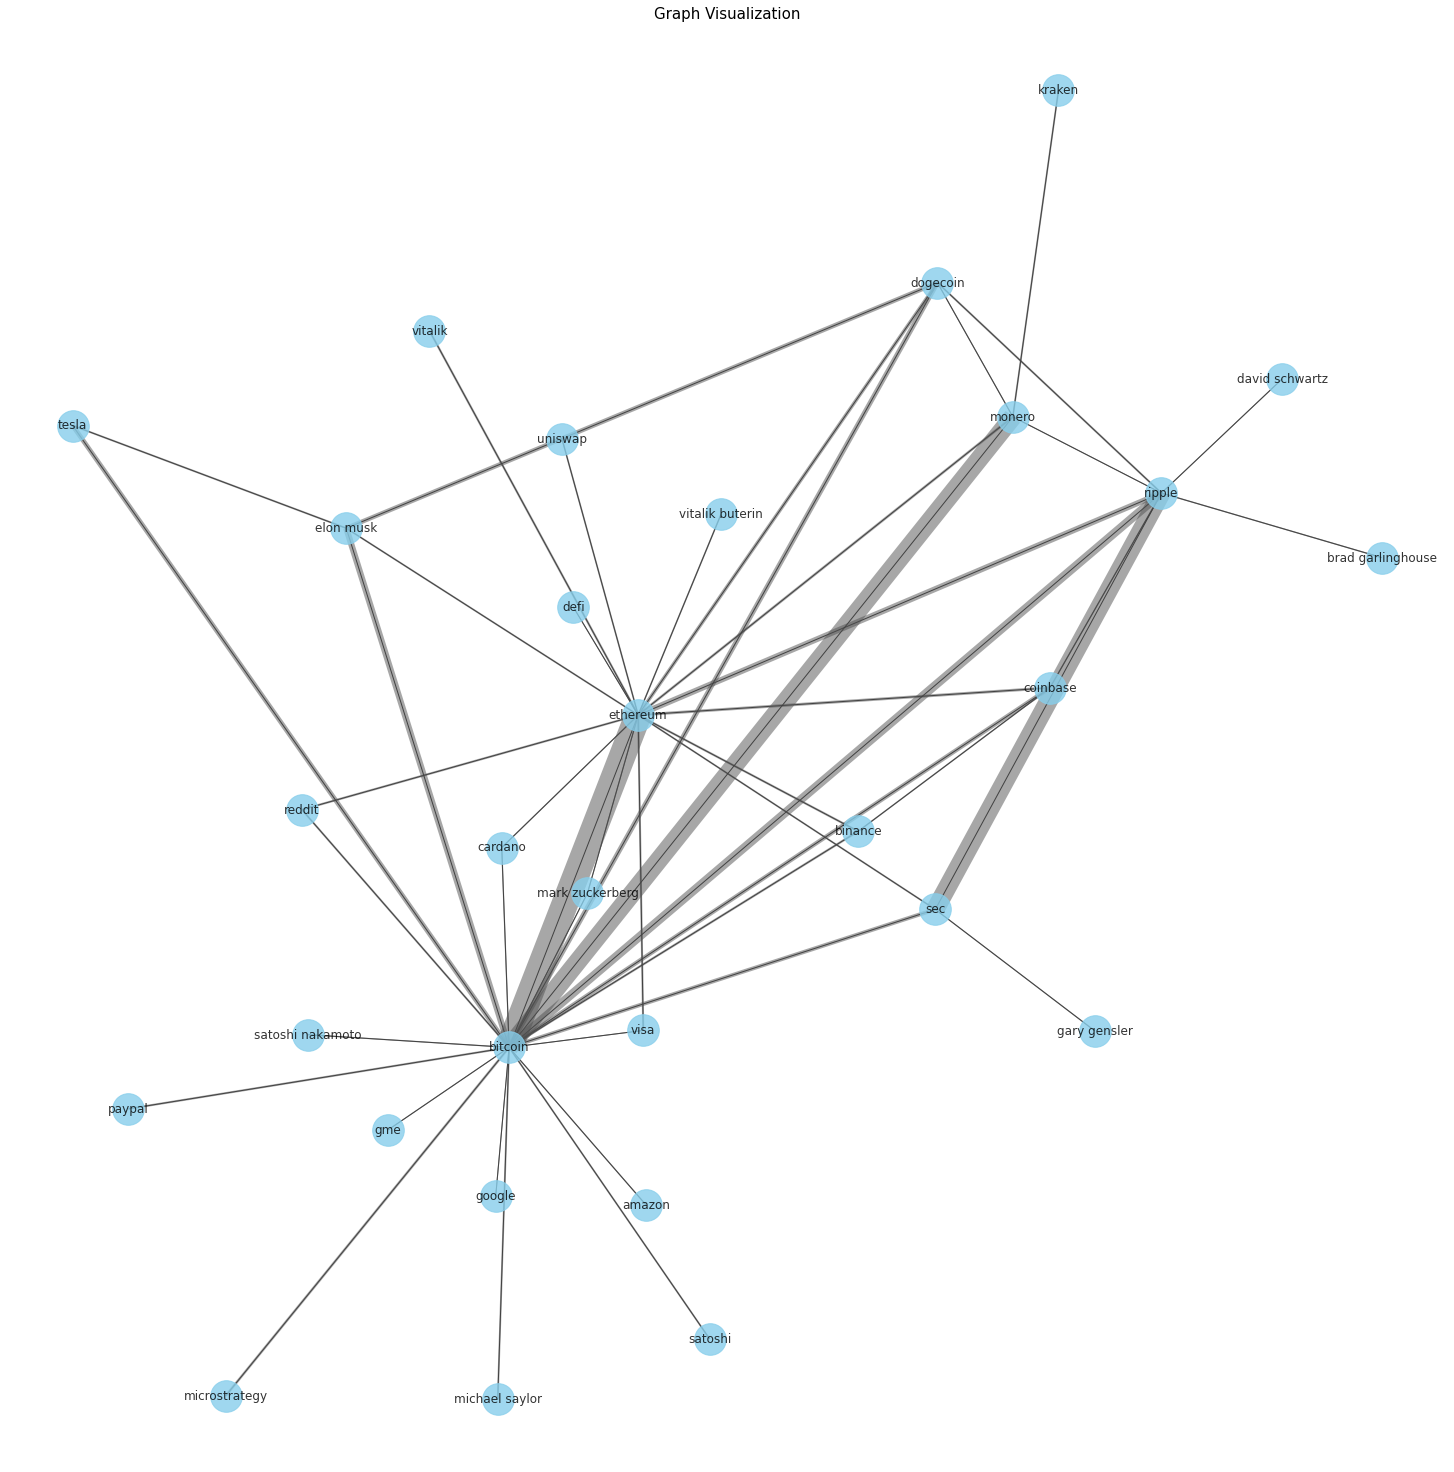

In [19]:
#Visualization with mathplotlib

# identify the greatest component (connected subgraph)
# and plot only that one
giant_component = sorted(nx.connected_components(graph), key=len, reverse=True)
graph = graph.subgraph(giant_component[0])

pos = nx.kamada_kawai_layout(graph, weight='weight')
# pos = nx.fruchterman_reingold_layout(graph, weight='weight')
# pos = nx.circular_layout(graph)

_ = plt.figure(figsize=(20, 20))
nx.draw(graph, pos, 
        node_size=1000, 
        node_color='skyblue',
        alpha=0.8,
        with_labels = True)
_ = plt.title('Graph Visualization', size=15)

for (node1,node2,data) in graph.edges(data=True):
    width = data['weight'] / 10
    _ = nx.draw_networkx_edges(graph,pos,
                               edgelist=[(node1, node2)],
                               width=width,
                               edge_color='#505050',
                               alpha=0.5)

Die obige Visualisierung ist mittels matplotlib erzeugt und ist optisch nicht die schönste. Alternativ kann dieser Graph auch mittels Gephi erzeugt werden. Dazu muss die Datei im Format .gexf gespeichert werden.  
Zusätzlich wird auch der Graph mit der Konfiguration 'weight>5' gespeichert, welcher mehrere Knoten/Kanten besitzt

In [22]:
#saving as GEXF format
nx.readwrite.write_gexf(graph, 'coin_coof_10.gexf', encoding='utf-8', 
                        prettyprint=True, version='1.2draft')

In [23]:
#save alternative version with weight > 5
graph_five = nx.from_pandas_edgelist(cooc_df.query('weight > 5')
                                ,source='source', target='target',edge_attr=True)
nx.readwrite.write_gexf(graph_five, 'coin_coof_5.gexf', encoding='utf-8', 
                        prettyprint=True, version='1.2draft')

[zurück zur Übersicht](./00_TXA-CC_Bericht.ipynb)